# Classification for Stars vs. Non-Stellar Objects 


#### In this notebook, we will explore the RefCat data for analyzing and extracting train data sets for **labels of stars**.

#### Some Issues:
- Repartitioned Reference Catalog is now fine. The direct conversions from astropy tables had many inefficient partition issues. 
- Huge Size of Data. Hence, we may need a memory-intensive configuration for the Spark Session.  

## Import Basic Packages 

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

# Increase display width to 200 characters
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 200)

In [2]:
import os

from astropy.table import Table
from matplotlib.ticker import MultipleLocator

from astropy.utils.exceptions import AstropyWarning
import warnings
warnings.simplefilter('ignore', category=AstropyWarning)

In [3]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## PySpark Session

In [4]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "200") \
    .config("spark.sql.hive.filesourcePartitionFileCacheSize", "2097152000") \
    .getOrCreate()



sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 13.9 ms, sys: 6.3 ms, total: 20.2 ms
Wall time: 32.3 s


> This takes time to get resources from the Yarn Cluster

## Reading Entire Catalog vs. Train Sample

In [5]:
!pwd

/home/shong/work/deeplearnings/star-classification/notebook


In [6]:
datapath = '/user/shong/data/spherex/star-classification/reduced-data/'
hdfsheader = 'hdfs://spark00:54310'
localdatapath= '/home/shong/work/deeplearnings/star-classification/data/'

In [7]:
hdfsheader+datapath+'RefCat-Flagged.parquet.snappy'

'hdfs://spark00:54310/user/shong/data/spherex/star-classification/reduced-data/RefCat-Flagged.parquet.snappy'

In [8]:
hdfsheader+datapath+'RefCat-Train.parquet.snappy'

'hdfs://spark00:54310/user/shong/data/spherex/star-classification/reduced-data/RefCat-Train.parquet.snappy'

In [9]:
%%time
flagdf = spark.read.option("header","true").parquet(hdfsheader+datapath+'RefCat-Flagged.parquet.snappy')

CPU times: user 1.57 ms, sys: 1.12 ms, total: 2.69 ms
Wall time: 2.23 s


In [10]:
%%time
traindf = spark.read.option("header","true").parquet(hdfsheader+datapath+'RefCat-Train.parquet.snappy')

CPU times: user 1.29 ms, sys: 801 µs, total: 2.09 ms
Wall time: 985 ms


In [11]:
flagdf.printSchema()

root
 |-- SPHERExRefID: long (nullable = true)
 |-- Gaia_DR3_source_id: long (nullable = true)
 |-- LegacySurvey_uid: long (nullable = true)
 |-- PS1_DR1_StackObject_objID: long (nullable = true)
 |-- CatWISE_source_id: string (nullable = true)
 |-- AllWISE_designation: string (nullable = true)
 |-- 2MASS_designation: string (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- ra_error: double (nullable = true)
 |-- dec_error: double (nullable = true)
 |-- coord_src: long (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmra_error: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- pmdec_error: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: double (nullable = true)
 |-- ref_epoch: double (nullable = true)
 |-- astrometric_params_solved: short (nullable = true)
 |-- CatWISE_PMRA: double (nullable = true)
 |-- CatWISE_PMDec: double (nullable = true)
 |-- CatWISE_sigPMRA: double (nullab

### Show some basic statistics and contents of `flagdf` and `traindf`

In [12]:
!ls {localdatapath}

histo-flag-refcat-pdf.parquet  sample-flagdf-show.parquet
mis-null-stats.parquet	       train-stats.parquet


In [13]:
sample_flagdf = pd.read_parquet('../data/sample-flagdf-show.parquet')

In [14]:
sample_flagdf.T

,0,1,2,3
SPHERExRefID,2397637034589028394,2573000184212488195,2564133125412093973,2565821885111599150
Gaia_DR3_source_id,4116757974710525440,4051095758790412288,4049855093088110464,4049850630618036736
LegacySurvey_uid,-9999,-9999,-9999,-9999
PS1_DR1_StackObject_objID,80722648871594149,72962757299530043,-9999,73292739654505964
CatWISE_source_id,N/A,N/A,N/A,N/A
AllWISE_designation,N/A,N/A,N/A,N/A
2MASS_designation,N/A,N/A,N/A,N/A
ra,264.887154,275.729773,274.200006,273.965485
dec,-22.730242,-29.200199,-28.860741,-28.920204
ra_error,0.0,0.0,0.000002,0.0


In [15]:
train_statsdf = pd.read_parquet('../data/train-stats.parquet')

In [16]:
train_statsdf.T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Gaia_G,97529175,648.6220104217754,2062.0059743030038,2.746002197265625,190015.5
Gaia_BP,97529175,462.86851167967654,1541.4972337272168,0.26731404662132263,156261.828125
Gaia_RP,97529175,937.5315135793138,2845.0395129623957,0.48395025730133057,382920.3125
Gaia_G_error,97529175,1.2522491313728379,3.9354252209600507,0.0683758735119389,1632.9657766341209
Gaia_BP_error,97529175,3.0201545809317323,6.767950088682359,6.225818832033819E-4,7305.160273729921
Gaia_RP_error,97529175,4.6977710710373435,9.34949313454147,0.0018402051802578405,9253.940722944228
LS_g,97529175,447.981538284785,283238.3264429876,-9907.498046875,2.744475904E9
LS_r,97529175,761.815166747817,195194.91597879824,-9896.0390625,1.521134336E9
LS_z,97529175,1043.1949743558885,145872.0280164497,-9361.9296875,1.342438016E9


# Bias Analyses 

### Legacy vs. Train Set

In [18]:
collegacy = ['LS_g','LS_r','LS_z','LS_g_error','LS_r_error','LS_z_error']

### `LS_g` 

In [156]:
tempbins = np.arange(51)*50000/50.0 - 10000
print(tempbins)

[-10000.  -9000.  -8000.  -7000.  -6000.  -5000.  -4000.  -3000.  -2000.
  -1000.      0.   1000.   2000.   3000.   4000.   5000.   6000.   7000.
   8000.   9000.  10000.  11000.  12000.  13000.  14000.  15000.  16000.
  17000.  18000.  19000.  20000.  21000.  22000.  23000.  24000.  25000.
  26000.  27000.  28000.  29000.  30000.  31000.  32000.  33000.  34000.
  35000.  36000.  37000.  38000.  39000.  40000.]


In [157]:
mygbins = tempbins.tolist()

In [158]:
%%time
gbins, gtraincounts = \
    traindf.select('LS_g').rdd.flatMap(lambda x: x).histogram(mygbins)

CPU times: user 23.4 ms, sys: 13.6 ms, total: 37 ms
Wall time: 5.7 s


In [218]:
leftgbins = [x - 500 for x in gbins]

### `LS_g_error` 

In [82]:
tempbins = np.arange(51)*100.0/50.0
print(tempbins)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100.]


In [83]:
mygrbins = tempbins.tolist()

In [84]:
%%time
grbins, grtraincounts = \
    traindf.select('LS_g_error').rdd.flatMap(lambda x: x).histogram(mygrbins)

CPU times: user 25.3 ms, sys: 9.68 ms, total: 35 ms
Wall time: 6.05 s


In [85]:
leftgrbins = [x - 1.0 for x in grbins]

### `LS_r` 

In [182]:
tempbins = np.arange(51)*50000/50.0 - 10000
print(tempbins)

[-10000.  -9000.  -8000.  -7000.  -6000.  -5000.  -4000.  -3000.  -2000.
  -1000.      0.   1000.   2000.   3000.   4000.   5000.   6000.   7000.
   8000.   9000.  10000.  11000.  12000.  13000.  14000.  15000.  16000.
  17000.  18000.  19000.  20000.  21000.  22000.  23000.  24000.  25000.
  26000.  27000.  28000.  29000.  30000.  31000.  32000.  33000.  34000.
  35000.  36000.  37000.  38000.  39000.  40000.]


In [183]:
myrbins = tempbins.tolist()

In [184]:
%%time
rbins, rtraincounts = \
    traindf.select('LS_r').rdd.flatMap(lambda x: x).histogram(myrbins)

CPU times: user 17.8 ms, sys: 16.4 ms, total: 34.2 ms
Wall time: 5.75 s


In [219]:
leftrbins = [x - 500 for x in rbins]

### LS_r_error

In [196]:
tempbins = np.arange(51)*130.0/50.0
print(tempbins)

[  0.    2.6   5.2   7.8  10.4  13.   15.6  18.2  20.8  23.4  26.   28.6
  31.2  33.8  36.4  39.   41.6  44.2  46.8  49.4  52.   54.6  57.2  59.8
  62.4  65.   67.6  70.2  72.8  75.4  78.   80.6  83.2  85.8  88.4  91.
  93.6  96.2  98.8 101.4 104.  106.6 109.2 111.8 114.4 117.  119.6 122.2
 124.8 127.4 130. ]


In [197]:
myrrbins = tempbins.tolist()

In [198]:
%%time
rrbins, rrtraincounts = \
    traindf.select('LS_r_error').rdd.flatMap(lambda x: x).histogram(myrrbins)

CPU times: user 27.2 ms, sys: 8.53 ms, total: 35.8 ms
Wall time: 5.56 s


In [199]:
leftrrbins = [x - 1.3 for x in rrbins]

### LS_z

In [242]:
tempbins = np.arange(52)*70000/50.0 - 11200
print(tempbins)

[-11200.  -9800.  -8400.  -7000.  -5600.  -4200.  -2800.  -1400.      0.
   1400.   2800.   4200.   5600.   7000.   8400.   9800.  11200.  12600.
  14000.  15400.  16800.  18200.  19600.  21000.  22400.  23800.  25200.
  26600.  28000.  29400.  30800.  32200.  33600.  35000.  36400.  37800.
  39200.  40600.  42000.  43400.  44800.  46200.  47600.  49000.  50400.
  51800.  53200.  54600.  56000.  57400.  58800.  60200.]


In [243]:
myzbins = tempbins.tolist()

In [244]:
%%time
zbins, ztraincounts = \
    traindf.select('LS_z').rdd.flatMap(lambda x: x).histogram(myzbins)

CPU times: user 20.4 ms, sys: 15.6 ms, total: 35.9 ms
Wall time: 6.18 s


In [245]:
leftzbins = [x - 700 for x in zbins]

### LS_z_error

In [105]:
tempbins = np.arange(51)*180.0/50.0
print(tempbins)

[  0.    3.6   7.2  10.8  14.4  18.   21.6  25.2  28.8  32.4  36.   39.6
  43.2  46.8  50.4  54.   57.6  61.2  64.8  68.4  72.   75.6  79.2  82.8
  86.4  90.   93.6  97.2 100.8 104.4 108.  111.6 115.2 118.8 122.4 126.
 129.6 133.2 136.8 140.4 144.  147.6 151.2 154.8 158.4 162.  165.6 169.2
 172.8 176.4 180. ]


In [106]:
myzrbins = tempbins.tolist()

In [107]:
%%time
zrbins, zrtraincounts = \
    traindf.select('LS_z_error').rdd.flatMap(lambda x: x).histogram(myzrbins)

CPU times: user 22.3 ms, sys: 13.4 ms, total: 35.7 ms
Wall time: 5.66 s


In [108]:
leftzrbins = [x - 1.8 for x in zrbins]

### Total Calculations

In [250]:
%%time
gbins, gtotalcounts = \
    flagdf.filter(F.col("LegacySurvey_uid") > -1). \
        select('LS_g').rdd.flatMap(lambda x: x).histogram(mygbins)

CPU times: user 257 ms, sys: 173 ms, total: 430 ms
Wall time: 45 s


In [252]:
%%time
grbins, grtotalcounts = \
    flagdf.filter(F.col("LegacySurvey_uid") > -1). \
        select('LS_g_error').rdd.flatMap(lambda x: x).histogram(mygrbins)

CPU times: user 252 ms, sys: 134 ms, total: 386 ms
Wall time: 40.1 s


In [253]:
%%time
rbins, rtotalcounts = \
    flagdf.filter(F.col("LegacySurvey_uid") > -1). \
        select('LS_r').rdd.flatMap(lambda x: x).histogram(myrbins)

CPU times: user 227 ms, sys: 157 ms, total: 384 ms
Wall time: 40.3 s


In [254]:
%%time
rrbins, rrtotalcounts = \
    flagdf.filter(F.col("LegacySurvey_uid") > -1). \
        select('LS_r_error').rdd.flatMap(lambda x: x).histogram(myrrbins)

CPU times: user 188 ms, sys: 188 ms, total: 376 ms
Wall time: 39.8 s


In [255]:
%%time
zbins, ztotalcounts = \
    flagdf.filter(F.col("LegacySurvey_uid") > -1). \
        select('LS_z').rdd.flatMap(lambda x: x).histogram(myzbins)

CPU times: user 204 ms, sys: 183 ms, total: 386 ms
Wall time: 40.2 s


In [256]:
%%time
zrbins, zrtotalcounts = \
    flagdf.filter(F.col("LegacySurvey_uid") > -1). \
        select('LS_z_error').rdd.flatMap(lambda x: x).histogram(myzrbins)

CPU times: user 240 ms, sys: 123 ms, total: 364 ms
Wall time: 39.5 s


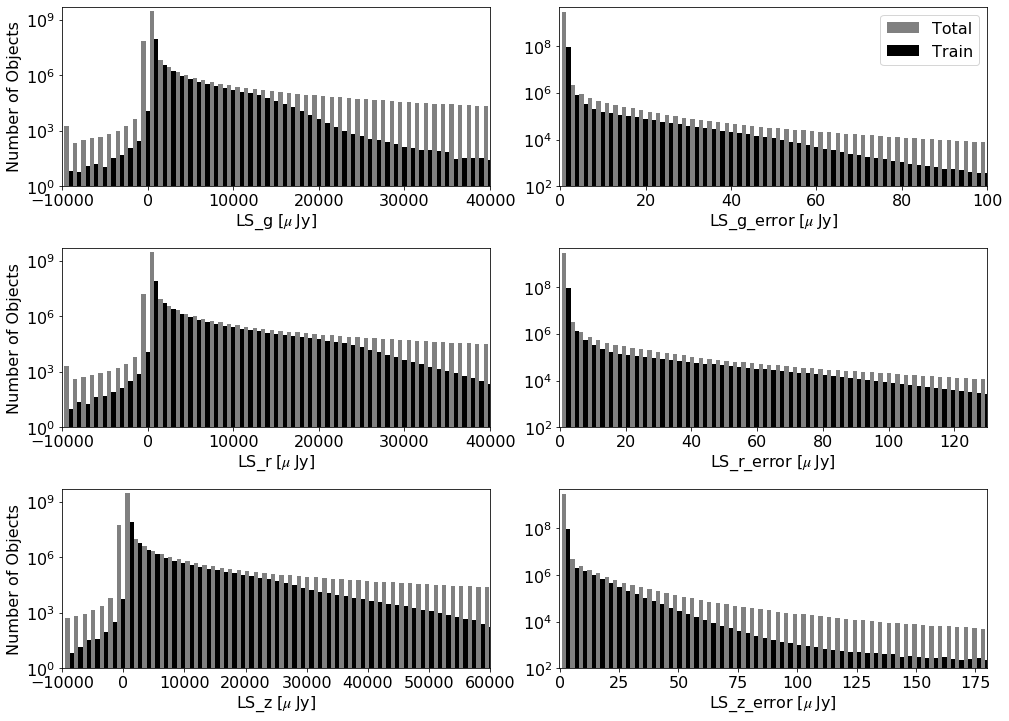

In [262]:
#bins, counts

#plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
#plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(14,10))

plt.subplot(321)
plt.axis([-10000,40000,1.0e00,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'LS_g [$\mu~$Jy]')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftgbins[1:],gtotalcounts,color='grey',width=500, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=500, label='Total')
plt.bar(gbins[1:],gtraincounts,color='black',width=500, label='Train')

# Add legend
#plt.legend()


plt.subplot(322)
plt.axis([-0.2,100,1.0e02,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'LS_g_error [$\mu~$Jy]')
#plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftgrbins[1:],grtotalcounts,color='grey',width=1.0, label='Total')
#plt.bar(leftgrbins[1:],grtraincounts,color='grey',width=1.0, label='Total')
plt.bar(grbins[1:],grtraincounts,color='black',width=1.0, label='Train')

# Add legend
plt.legend()


plt.subplot(323)
plt.axis([-10000,40000,1.0e00,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'LS_r [$\mu~$Jy]')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftrbins[1:],rtotalcounts,color='grey',width=500, label='Total')
#plt.bar(leftrbins[1:],rtraincounts,color='grey',width=500, label='Total')
plt.bar(rbins[1:],rtraincounts,color='black',width=500, label='Train')


plt.subplot(324)
plt.axis([-0.2,130,1.0e02,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'LS_r_error [$\mu~$Jy]')
#plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftrrbins[1:],rrtotalcounts,color='grey',width=1.3, label='Total')
#plt.bar(leftrrbins[1:],rrtraincounts,color='grey',width=1.3, label='Total')
plt.bar(rrbins[1:],rrtraincounts,color='black',width=1.3, label='Train')


plt.subplot(325)
plt.axis([-10000,60000,1.0e00,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'LS_z [$\mu~$Jy]')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftzbins[1:],ztotalcounts,color='grey',width=700, label='Total')
#plt.bar(leftzbins[1:],ztraincounts,color='grey',width=700, label='Total')
plt.bar(zbins[1:],ztraincounts,color='black',width=700, label='Train')




plt.subplot(326)
plt.axis([-0.2,180,1.0e02,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'LS_z_error [$\mu~$Jy]')
#plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftzrbins[1:],zrtotalcounts,color='grey',width=1.8, label='Total')
#plt.bar(leftzrbins[1:],zrtraincounts,color='grey',width=1.8, label='Total')
plt.bar(zrbins[1:],zrtraincounts,color='black',width=1.8, label='Train')




plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("histo_legacy.pdf")

plt.show()

> **Our training sample** is biased; less sampling for larger **errors or fluxes**. But the fraction is small; could be less than several percents. 